In [29]:
import gym
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [30]:
class CartPole_Duel_DQN(nn.Module):
    def __init__(self):
        super(CartPole_Duel_DQN, self).__init__()
        
        self.fc1_val = nn.Linear(4, 1024)
        self.fc2_val = nn.Linear(1024, 128)
        self.fc3_val = nn.Linear(128, 1)
        
        self.fc1_adv = nn.Linear(4, 1024)
        self.fc2_adv = nn.Linear(1024, 128)
        self.fc3_adv = nn.Linear(128, 2)
        
    def forward(self, x):
        val = F.relu(self.fc1_val(x))
        val = F.relu(self.fc2_val(val))
        val = self.fc3_val(val)
        
        adv = F.relu(self.fc1_adv(x))
        adv = F.relu(self.fc2_adv(adv))
        adv = self.fc3_adv(adv)
        
        q = val + (adv - adv.mean())
        return q

In [39]:
class Dueling_CartPole_Agent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.replay_memory = list()
        self.N = 8192
        self.batch_size = 32
        self.COUNTER_MAX = 16
        self.refresh_counter = self.COUNTER_MAX
        self.current_state = torch.zeros(4,1)
        self.Q = CartPole_Duel_DQN()
        self.frozen_Q = copy.deepcopy(self.Q)
        self.frozen_Q.eval()
        self.epsilon = 1
        self.alpha = .001
        self.gamma = .7
        self.optimizer = optim.SGD(self.Q.parameters(), lr = self.alpha)
        self.criterion = nn.MSELoss()
        self.previous_state = None
        self.previous_action = None
        
    def load(self, filename):
        self.Q.load_state_dict(torch.load('./{}-weights.pth'.format(filename)))
    
    def save(self, filename):
        torch.save(self.Q.state_dict(), './{}-weights.pth'.format(filename))
        
    def step(self, observation):
        observation = torch.from_numpy(observation)
        explore_or_exploit = random.random()
        action = None
        if explore_or_exploit < self.epsilon:
            action = np.random.choice(self.action_space.n)
        else:
            self.current_state = observation
            with torch.no_grad():
                action = torch.argmax(self.Q(observation))
                action = action.int().item()
        self.previous_state = observation
        self.previous_action = action
        return action
    
    def observe(self, observation, reward, done):
        observation = torch.from_numpy(observation)
        reward = torch.tensor(reward)
        self.current_state = observation.float()
        self.replay_memory.append((self.previous_state, self.previous_action, reward, self.current_state, done))
        if len(self.replay_memory) > self.N:
            del self.replay_memory[int(self.N/8)]
            
    def replay(self):
        if len(self.replay_memory) < self.batch_size:
            return
        
        batch_indices = random.sample(range(len(self.replay_memory)), self.batch_size)
        for index in batch_indices:
            sample = self.replay_memory[index]
            state = sample[0]
            action = sample[1]
            reward = sample[2]
            next_state = sample[3]
            done = sample[4]
            
            if done == True:
                target = reward
            else:
                target = reward + self.gamma * torch.max(self.frozen_Q(next_state))
            
            output = self.Q(state)
            output = output[action] #get the value of action taken
            
            loss = self.criterion(output, target) #loss will be based on action value and target
            self.optimizer.zero_grad()
            loss.backward()
            for parameter in self.Q.parameters():
                parameter.grad.data.clamp_(-1,1)
            self.optimizer.step()
            
            self.refresh_counter -=1
            if self.refresh_counter <= 0:
                self.refresh_counter = self.COUNTER_MAX
                self.frozen_Q = copy.deepcopy(self.Q)
    
    def reset(self):
        self.replay_memory.clear()
        self.refresh_counter = self.COUNTER_MAX
        self.frozen_Q = copy.deepycopy(self.Q)
        self.current_state = torch.zeros(4,1)

In [40]:
EPISODES = 1000
MAX_TIMESTEPS = 1000

In [41]:
env = gym.make('CartPole-v1')
agent = Dueling_CartPole_Agent(env)

In [42]:
y_rewards = list()
y_average = list()
y_epsilon = list()
x_axis = list()
x_epsilon = list()

epsilon_decay_rate = 0.995

rewards = 0
average_reward = 0

for i_episode in range(EPISODES):
    episode_reward = 0
    observation = env.reset()
    for t in range(MAX_TIMESTEPS):
        #Jupyter notebook can't render
        #if i_episode > EPISODES-10:
        #    env.render()
        action = agent.step(observation)
        observation, reward, done, info = env.step(action)
        episode_reward += reward
        agent.observe(observation, reward, done)
        if done:
            average_reward = average_reward + (episode_reward - average_reward)/(i_episode+1)
            if i_episode % (EPISODES/100) == 0:
                print("Episode {}: average: {} current reward: {}".format(i_episode, average_reward, episode_reward))
                y_rewards.append(episode_reward)
                y_average.append(average_reward)
                x_axis.append(i_episode)
            break
    agent.replay()
    y_epsilon.append(agent.epsilon)
    x_epsilon.append(i_episode)
    agent.epsilon *= epsilon_decay_rate

Episode 0: average: 21.0 current reward: 21.0
Episode 10: average: 23.09090909090909 current reward: 40.0
Episode 20: average: 20.57142857142857 current reward: 10.0
Episode 30: average: 20.322580645161292 current reward: 28.0
Episode 40: average: 22.58536585365854 current reward: 33.0
Episode 50: average: 23.01960784313726 current reward: 32.0
Episode 60: average: 22.885245901639347 current reward: 25.0
Episode 70: average: 23.323943661971832 current reward: 17.0
Episode 80: average: 23.148148148148152 current reward: 19.0
Episode 90: average: 24.252747252747255 current reward: 47.0
Episode 100: average: 26.77227722772277 current reward: 42.0
Episode 110: average: 28.36936936936937 current reward: 44.0
Episode 120: average: 30.231404958677683 current reward: 12.0
Episode 130: average: 30.717557251908392 current reward: 82.0
Episode 140: average: 32.205673758865245 current reward: 64.0
Episode 150: average: 33.4701986754967 current reward: 33.0
Episode 160: average: 34.54037267080746 c

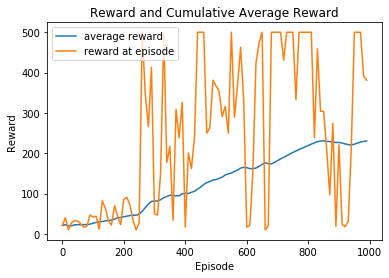

In [43]:
plt.title('Reward and Cumulative Average Reward')
plt.plot(x_axis, y_average, label='average reward')
plt.plot(x_axis, y_rewards, label='reward at episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

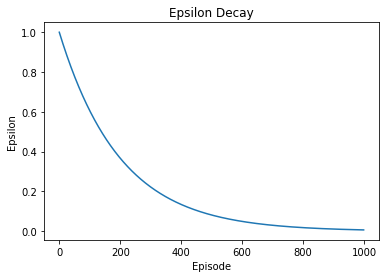

In [44]:
plt.title('Epsilon Decay')
plt.plot(x_epsilon, y_epsilon)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [45]:
agent.save("cartpole")
env.close()

Everything below here is pretty much useless because I can't render without a screen. Need to download the model and run it locally.

In [26]:
env = gym.make('CartPole-v1')
agent = Dueling_CartPole_Agent(env)
agent.load('cartpole')

In [28]:
y_rewards = list()
y_average = list()
y_epsilon = list()
x_axis = list()
x_epsilon = list()

agent.epsilon = 0

rewards = 0
average_reward = 0

for i_episode in range(1):
    episode_reward = 0
    observation = env.reset()
    for t in range(MAX_TIMESTEPS):
        render = env.render(mode='rgb_array')
        print(render)
        action = agent.step(observation)
        observation, reward, done, info = env.step(action)
        episode_reward += reward
        if done:
            average_reward = average_reward + (episode_reward - average_reward)/(i_episode+1)
            if i_episode % (EPISODES/100) == 0:
                print("Episode {}: average: {} current reward: {}".format(i_episode, average_reward, episode_reward))
                y_rewards.append(episode_reward)
                y_average.append(average_reward)
                x_axis.append(i_episode)
            break
    y_epsilon.append(agent.epsilon)
    x_epsilon.append(i_episode)

GLException: No GL context; create a Window first